<h2> DQN Agent <h2>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series

        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)

            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise

            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)

            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion

            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None

    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]

    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])

            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()

            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)

            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants

    return best_params, best_error

In [18]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [19]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.2]
Best error: 0.14599292629028598


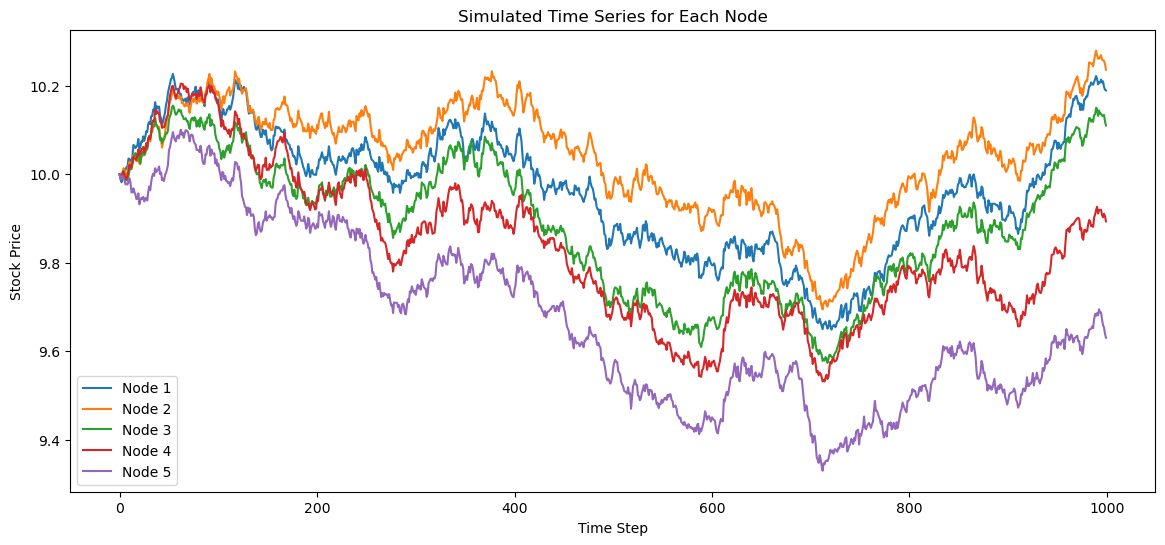

In [20]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

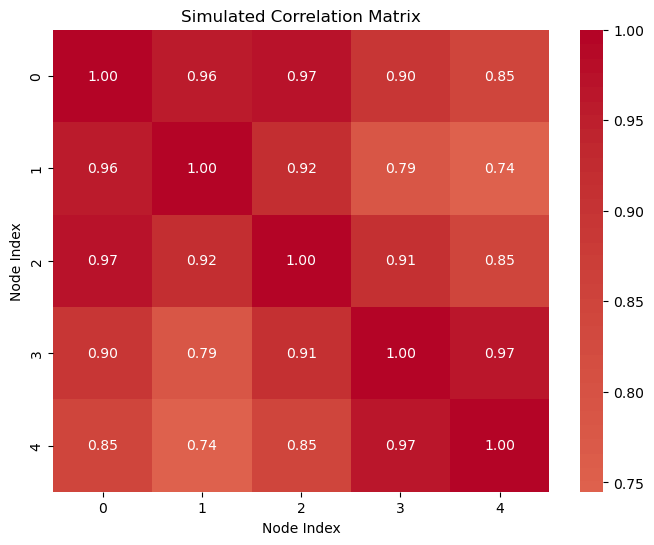

In [21]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [22]:
#Time series of a single node rescaled to match a stock-price

import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 2  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 150
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})

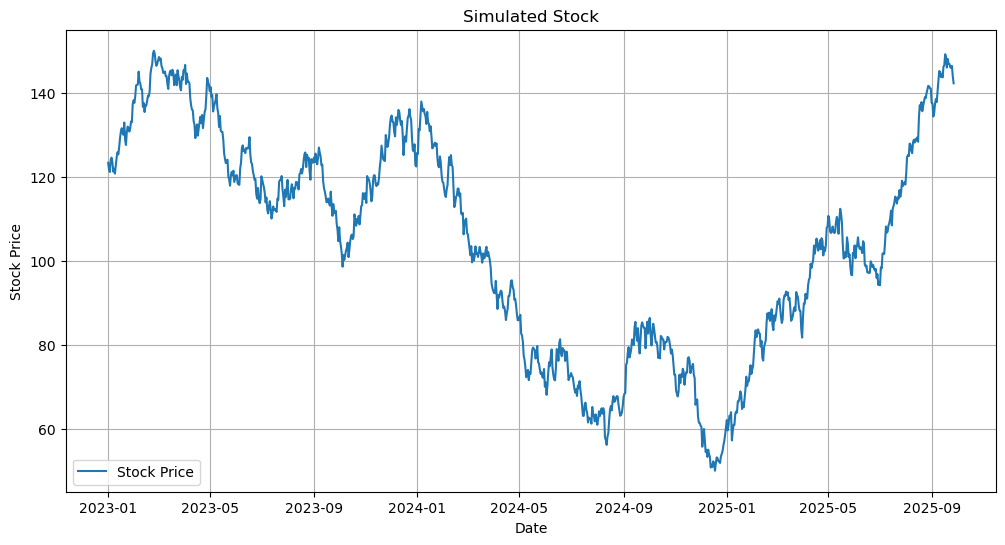

In [23]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()

In [34]:
import numpy as np
import random
from collections import deque
import pickle

class StockTradingEnvironment:
    def __init__(self, stock_prices, transaction_fee=0.001):
        self.stock_prices = stock_prices
        self.transaction_fee = transaction_fee
        self.current_step = 0
        self.balance = 1000  # Initial balance
        self.shares = 0  # Initial shares held

    def reset(self):
        self.current_step = 0
        self.balance = 1000
        self.shares = 0
        print(f"Environment reset. Initial balance: {self.balance}, Shares: {self.shares}")
        return self.get_state(self.current_step)

    def get_state(self, step, window_size=5):
        # Create a state representation (last `window_size` prices)
        start = max(0, step - window_size + 1)
        state = self.stock_prices[start:step + 1]
        state = np.pad(state, (0, window_size - len(state)), 'constant', constant_values=0)
        return state

    def take_action(self, action):
        current_price = self.stock_prices[self.current_step]
        reward = 0

        if action == 0:  # Hold
            if self.current_step > 0 and self.stock_prices[self.current_step] > self.stock_prices[self.current_step - 1]:
                reward = 0.1  # Reward for holding if the price has increased
            else:
                reward = -0.01  # Small penalty for holding
            action_str = "Hold"
        
        elif action == 1:  # Buy
            if self.balance >= current_price:
                self.shares += 1
                self.balance -= current_price * (1 + self.transaction_fee)  # Account for transaction fee
                reward = -0.05  # Small negative reward for buying
                action_str = "Buy"
            else:
                reward = -1  # Not enough balance to buy
                action_str = "Buy (Failed)"
        
        elif action == 2:  # Sell
            if self.shares > 0:
                sale_amount = current_price * (1 - self.transaction_fee)
                self.balance += sale_amount
                profit = sale_amount - current_price  # Profit from selling
                self.shares -= 1
                reward = profit + 0.1  # Positive reward for selling, plus a small bonus
                action_str = "Sell"
            else:
                reward = -1  # No shares to sell
                action_str = "Sell (Failed)"

        # Move to the next step
        self.current_step += 1
        done = self.current_step >= len(self.stock_prices) - 1  # End if we reach the last price

        print(f"Step: {self.current_step}, Action: {action_str}, "
              f"Current Price: {current_price:.2f}, "
              f"Balance: {self.balance:.2f}, Shares: {self.shares}, "
              f"Reward: {reward:.2f}")

        return self.get_state(self.current_step), reward, done

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)  # Replay memory
        self.gamma = 0.95  # Discount rate
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Simple neural network model
        from keras.models import Sequential
        from keras.layers import Dense

        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse', optimizer='adam')
        return model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Explore
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])  # Exploit

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return

        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target += self.gamma * np.amax(self.model.predict(next_state)[0])
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def get_q_values(self, state):
        """ Extract Q-values for a given state """
        return self.model.predict(np.reshape(state, [1, self.state_size]))

    def save_q_values(self, states, filename):
        """ Save the Q-values for all given states to a file """
        q_values = np.array([self.get_q_values(state) for state in states])
        np.save(filename, q_values)

    def load_model(self, name):
        """ Load a saved model """
        self.model.load_weights(name)

    def save_model(self, name):
        """ Save the model weights """
        self.model.save_weights(name)
            

class StockTradingAgent:
    def __init__(self, stock_prices):
        self.env = StockTradingEnvironment(stock_prices)
        self.state_size = 5  # Window size for state representation
        self.action_size = 3  # Hold, Buy, Sell
        self.agent = DQNAgent(self.state_size, self.action_size)

    def train(self, epochs, batch_size=32):
        for e in range(epochs):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])

            for time in range(len(self.env.stock_prices) - 1):
                action = self.agent.choose_action(state)
                next_state, reward, done = self.env.take_action(action)
                next_state = np.reshape(next_state, [1, self.state_size])
                self.agent.remember(state, action, reward, next_state, done)

                state = next_state

                if done:
                    total_value = self.env.balance + self.env.shares * self.env.stock_prices[self.env.current_step]
                    print(f"Episode: {e + 1}/{epochs}, Total Value: {total_value:.2f}, Epsilon: {self.agent.epsilon:.2}")
                    break

                self.agent.replay(batch_size)

    def save_q_values(self, filename):
        """ Extract and save the Q-values for all states in the stock price history """
        all_states = [self.env.get_state(t) for t in range(len(self.env.stock_prices))]
        self.agent.save_q_values(all_states, filename)

In [35]:
# Initialize and train the multi-agent trading bot with an initial balance of $100,000 per agent
agent = StockTradingAgent(df['StockPrice'])
agent.train(epochs=1, batch_size=32)
# Save the model after training
agent.agent.save_model("dqn_agent.h5")

Environment reset. Initial balance: 1000, Shares: 0
Step: 1, Action: Sell (Failed), Current Price: 123.32, Balance: 1000.00, Shares: 0, Reward: -1.00
Step: 2, Action: Buy, Current Price: 121.69, Balance: 878.19, Shares: 1, Reward: -0.05
Step: 3, Action: Buy, Current Price: 121.12, Balance: 756.94, Shares: 2, Reward: -0.05
Step: 4, Action: Buy, Current Price: 124.02, Balance: 632.80, Shares: 3, Reward: -0.05
Step: 5, Action: Hold, Current Price: 124.55, Balance: 632.80, Shares: 3, Reward: 0.10
Step: 6, Action: Sell, Current Price: 123.46, Balance: 756.13, Shares: 2, Reward: -0.02
Step: 7, Action: Sell, Current Price: 121.21, Balance: 877.23, Shares: 1, Reward: -0.02
Step: 8, Action: Buy, Current Price: 121.91, Balance: 755.19, Shares: 2, Reward: -0.05
Step: 9, Action: Buy, Current Price: 120.75, Balance: 634.33, Shares: 3, Reward: -0.05
Step: 10, Action: Sell, Current Price: 122.66, Balance: 756.86, Shares: 2, Reward: -0.02
Step: 11, Action: Buy, Current Price: 124.60, Balance: 632.14, 

Step: 93, Action: Buy, Current Price: 142.08, Balance: 484.83, Shares: 4, Reward: -0.05
Step: 94, Action: Hold, Current Price: 144.57, Balance: 484.83, Shares: 4, Reward: 0.10
Step: 95, Action: Sell, Current Price: 142.61, Balance: 627.30, Shares: 3, Reward: -0.04
Step: 96, Action: Buy, Current Price: 142.61, Balance: 484.55, Shares: 4, Reward: -0.05
Step: 97, Action: Sell, Current Price: 142.27, Balance: 626.68, Shares: 3, Reward: -0.04
Step: 98, Action: Hold, Current Price: 138.66, Balance: 626.68, Shares: 3, Reward: -0.01
Step: 99, Action: Sell, Current Price: 136.98, Balance: 763.52, Shares: 2, Reward: -0.04
Step: 100, Action: Hold, Current Price: 136.00, Balance: 763.52, Shares: 2, Reward: -0.01
Step: 101, Action: Buy, Current Price: 135.75, Balance: 627.64, Shares: 3, Reward: -0.05
Step: 102, Action: Buy, Current Price: 133.23, Balance: 494.27, Shares: 4, Reward: -0.05
Step: 103, Action: Hold, Current Price: 132.38, Balance: 494.27, Shares: 4, Reward: -0.01
Step: 104, Action: Buy

Step: 185, Action: Buy (Failed), Current Price: 117.51, Balance: 40.60, Shares: 8, Reward: -1.00
Step: 186, Action: Hold, Current Price: 116.16, Balance: 40.60, Shares: 8, Reward: -0.01
Step: 187, Action: Sell, Current Price: 113.90, Balance: 154.38, Shares: 7, Reward: -0.01
Step: 188, Action: Hold, Current Price: 115.07, Balance: 154.38, Shares: 7, Reward: 0.10
Step: 189, Action: Sell, Current Price: 112.14, Balance: 266.41, Shares: 6, Reward: -0.01
Step: 190, Action: Buy, Current Price: 111.26, Balance: 155.05, Shares: 7, Reward: -0.05
Step: 191, Action: Hold, Current Price: 112.90, Balance: 155.05, Shares: 7, Reward: 0.10
Step: 192, Action: Buy, Current Price: 114.18, Balance: 40.75, Shares: 8, Reward: -0.05
Step: 193, Action: Sell, Current Price: 112.34, Balance: 152.99, Shares: 7, Reward: -0.01
Step: 194, Action: Sell, Current Price: 110.04, Balance: 262.92, Shares: 6, Reward: -0.01
Step: 195, Action: Sell, Current Price: 111.22, Balance: 374.03, Shares: 5, Reward: -0.01
Step: 196

Step: 278, Action: Sell, Current Price: 98.57, Balance: 533.67, Shares: 3, Reward: 0.00
Step: 279, Action: Hold, Current Price: 101.33, Balance: 533.67, Shares: 3, Reward: 0.10
Step: 280, Action: Hold, Current Price: 100.19, Balance: 533.67, Shares: 3, Reward: -0.01
Step: 281, Action: Hold, Current Price: 101.27, Balance: 533.67, Shares: 3, Reward: 0.10
Step: 282, Action: Sell, Current Price: 102.36, Balance: 635.92, Shares: 2, Reward: -0.00
Step: 283, Action: Sell, Current Price: 103.12, Balance: 738.94, Shares: 1, Reward: -0.00
Step: 284, Action: Buy, Current Price: 104.32, Balance: 634.52, Shares: 2, Reward: -0.05
Step: 285, Action: Buy, Current Price: 100.86, Balance: 533.56, Shares: 3, Reward: -0.05
Step: 286, Action: Sell, Current Price: 102.51, Balance: 635.97, Shares: 2, Reward: -0.00
Step: 287, Action: Hold, Current Price: 104.67, Balance: 635.97, Shares: 2, Reward: 0.10
Step: 288, Action: Sell, Current Price: 105.90, Balance: 741.77, Shares: 1, Reward: -0.01
Step: 289, Action

Step: 371, Action: Hold, Current Price: 137.91, Balance: 135.45, Shares: 6, Reward: 0.10
Step: 372, Action: Buy (Failed), Current Price: 136.71, Balance: 135.45, Shares: 6, Reward: -1.00
Step: 373, Action: Sell, Current Price: 135.58, Balance: 270.89, Shares: 5, Reward: -0.04
Step: 374, Action: Hold, Current Price: 136.14, Balance: 270.89, Shares: 5, Reward: 0.10
Step: 375, Action: Hold, Current Price: 134.99, Balance: 270.89, Shares: 5, Reward: -0.01
Step: 376, Action: Buy, Current Price: 134.34, Balance: 136.42, Shares: 6, Reward: -0.05
Step: 377, Action: Sell, Current Price: 132.55, Balance: 268.84, Shares: 5, Reward: -0.03
Step: 378, Action: Buy, Current Price: 135.42, Balance: 133.28, Shares: 6, Reward: -0.05
Step: 379, Action: Sell, Current Price: 132.83, Balance: 265.98, Shares: 5, Reward: -0.03
Step: 380, Action: Sell, Current Price: 132.59, Balance: 398.43, Shares: 4, Reward: -0.03
Step: 381, Action: Sell, Current Price: 130.84, Balance: 529.14, Shares: 3, Reward: -0.03
Step: 

Step: 462, Action: Hold, Current Price: 91.79, Balance: 714.54, Shares: 0, Reward: 0.10
Step: 463, Action: Hold, Current Price: 91.23, Balance: 714.54, Shares: 0, Reward: -0.01
Step: 464, Action: Hold, Current Price: 92.23, Balance: 714.54, Shares: 0, Reward: 0.10
Step: 465, Action: Sell (Failed), Current Price: 92.88, Balance: 714.54, Shares: 0, Reward: -1.00
Step: 466, Action: Sell (Failed), Current Price: 92.58, Balance: 714.54, Shares: 0, Reward: -1.00
Step: 467, Action: Buy, Current Price: 90.20, Balance: 624.25, Shares: 1, Reward: -0.05
Step: 468, Action: Hold, Current Price: 88.75, Balance: 624.25, Shares: 1, Reward: -0.01
Step: 469, Action: Sell, Current Price: 89.06, Balance: 713.22, Shares: 0, Reward: 0.01
Step: 470, Action: Hold, Current Price: 87.93, Balance: 713.22, Shares: 0, Reward: -0.01
Step: 471, Action: Sell (Failed), Current Price: 85.88, Balance: 713.22, Shares: 0, Reward: -1.00
Step: 472, Action: Sell (Failed), Current Price: 87.49, Balance: 713.22, Shares: 0, Rew

Step: 554, Action: Hold, Current Price: 69.40, Balance: 682.84, Shares: 0, Reward: 0.10
Step: 555, Action: Hold, Current Price: 67.81, Balance: 682.84, Shares: 0, Reward: -0.01
Step: 556, Action: Hold, Current Price: 70.30, Balance: 682.84, Shares: 0, Reward: 0.10
Step: 557, Action: Hold, Current Price: 69.65, Balance: 682.84, Shares: 0, Reward: -0.01
Step: 558, Action: Sell (Failed), Current Price: 71.33, Balance: 682.84, Shares: 0, Reward: -1.00
Step: 559, Action: Hold, Current Price: 69.28, Balance: 682.84, Shares: 0, Reward: -0.01
Step: 560, Action: Sell (Failed), Current Price: 67.71, Balance: 682.84, Shares: 0, Reward: -1.00
Step: 561, Action: Hold, Current Price: 65.39, Balance: 682.84, Shares: 0, Reward: -0.01
Step: 562, Action: Hold, Current Price: 63.05, Balance: 682.84, Shares: 0, Reward: -0.01
Step: 563, Action: Sell (Failed), Current Price: 63.09, Balance: 682.84, Shares: 0, Reward: -1.00
Step: 564, Action: Buy, Current Price: 65.75, Balance: 617.03, Shares: 1, Reward: -0.

Step: 648, Action: Hold, Current Price: 80.53, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 649, Action: Hold, Current Price: 80.67, Balance: 603.05, Shares: 1, Reward: 0.10
Step: 650, Action: Hold, Current Price: 79.46, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 651, Action: Hold, Current Price: 76.86, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 652, Action: Hold, Current Price: 77.76, Balance: 603.05, Shares: 1, Reward: 0.10
Step: 653, Action: Hold, Current Price: 76.76, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 654, Action: Hold, Current Price: 82.09, Balance: 603.05, Shares: 1, Reward: 0.10
Step: 655, Action: Hold, Current Price: 81.81, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 656, Action: Hold, Current Price: 81.31, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 657, Action: Hold, Current Price: 81.24, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 658, Action: Hold, Current Price: 78.88, Balance: 603.05, Shares: 1, Reward: -0.01
Step: 659, Action: Hold,

Step: 742, Action: Hold, Current Price: 63.53, Balance: 665.35, Shares: 0, Reward: 0.10
Step: 743, Action: Hold, Current Price: 64.10, Balance: 665.35, Shares: 0, Reward: 0.10
Step: 744, Action: Hold, Current Price: 63.84, Balance: 665.35, Shares: 0, Reward: -0.01
Step: 745, Action: Sell (Failed), Current Price: 66.51, Balance: 665.35, Shares: 0, Reward: -1.00
Step: 746, Action: Hold, Current Price: 66.53, Balance: 665.35, Shares: 0, Reward: 0.10
Step: 747, Action: Hold, Current Price: 67.30, Balance: 665.35, Shares: 0, Reward: 0.10
Step: 748, Action: Hold, Current Price: 68.89, Balance: 665.35, Shares: 0, Reward: 0.10
Step: 749, Action: Hold, Current Price: 68.03, Balance: 665.35, Shares: 0, Reward: -0.01
Step: 750, Action: Hold, Current Price: 64.70, Balance: 665.35, Shares: 0, Reward: -0.01
Step: 751, Action: Hold, Current Price: 66.20, Balance: 665.35, Shares: 0, Reward: 0.10
Step: 752, Action: Hold, Current Price: 65.11, Balance: 665.35, Shares: 0, Reward: -0.01
Step: 753, Action:

Step: 835, Action: Hold, Current Price: 103.60, Balance: 571.17, Shares: 1, Reward: 0.10
Step: 836, Action: Hold, Current Price: 101.72, Balance: 571.17, Shares: 1, Reward: -0.01
Step: 837, Action: Hold, Current Price: 103.46, Balance: 571.17, Shares: 1, Reward: 0.10
Step: 838, Action: Hold, Current Price: 105.27, Balance: 571.17, Shares: 1, Reward: 0.10
Step: 839, Action: Hold, Current Price: 103.93, Balance: 571.17, Shares: 1, Reward: -0.01
Step: 840, Action: Hold, Current Price: 102.40, Balance: 571.17, Shares: 1, Reward: -0.01
Step: 841, Action: Hold, Current Price: 103.56, Balance: 571.17, Shares: 1, Reward: 0.10
Step: 842, Action: Hold, Current Price: 104.87, Balance: 571.17, Shares: 1, Reward: 0.10
Step: 843, Action: Hold, Current Price: 102.73, Balance: 571.17, Shares: 1, Reward: -0.01
Step: 844, Action: Hold, Current Price: 105.37, Balance: 571.17, Shares: 1, Reward: 0.10
Step: 845, Action: Hold, Current Price: 104.77, Balance: 571.17, Shares: 1, Reward: -0.01
Step: 846, Actio

Step: 927, Action: Hold, Current Price: 108.41, Balance: 569.95, Shares: 1, Reward: -0.01
Step: 928, Action: Hold, Current Price: 112.36, Balance: 569.95, Shares: 1, Reward: 0.10
Step: 929, Action: Hold, Current Price: 113.00, Balance: 569.95, Shares: 1, Reward: 0.10
Step: 930, Action: Hold, Current Price: 113.88, Balance: 569.95, Shares: 1, Reward: 0.10
Step: 931, Action: Buy, Current Price: 115.27, Balance: 454.57, Shares: 2, Reward: -0.05
Step: 932, Action: Hold, Current Price: 114.70, Balance: 454.57, Shares: 2, Reward: -0.01
Step: 933, Action: Hold, Current Price: 113.60, Balance: 454.57, Shares: 2, Reward: -0.01
Step: 934, Action: Hold, Current Price: 115.09, Balance: 454.57, Shares: 2, Reward: 0.10
Step: 935, Action: Hold, Current Price: 114.76, Balance: 454.57, Shares: 2, Reward: -0.01
Step: 936, Action: Hold, Current Price: 116.82, Balance: 454.57, Shares: 2, Reward: 0.10
Step: 937, Action: Hold, Current Price: 115.22, Balance: 454.57, Shares: 2, Reward: -0.01
Step: 938, Actio

In [36]:
agent.save_q_values(filename="dqn_qvalues.npy")

In [37]:
#Try the model on some simulated data

import numpy as np

# Load the trained agent
agent = StockTradingAgent(stock_prices=None)  # We don't need initial stock prices for loading
agent.agent.load_model("dqn_agent.h5")

# New stock price data for testing (example data)
new_stock_prices = np.array([100, 101, 102, 103, 102, 101, 104, 105, 106])  # Replace with your new prices

# Initialize the environment with new stock prices
test_env = StockTradingEnvironment(new_stock_prices, transaction_fee=0.001)

# Reset the environment to get the initial state
state = test_env.reset()
state = np.reshape(state, [1, agent.state_size])  # Reshape for the model input

# Simulate the trading environment using the loaded model
done = False
while not done:
    action = agent.agent.choose_action(state)  # Choose action based on the loaded model
    next_state, reward, done = test_env.take_action(action)  # Take action in the environment
    next_state = np.reshape(next_state, [1, agent.state_size])  # Reshape for the next state
    state = next_state  # Update the state for the next iteration

# After the loop, print the final results
total_value = test_env.balance + test_env.shares * test_env.stock_prices[test_env.current_step]
print(f"Final Total Value: {total_value:.2f}, Final Balance: {test_env.balance:.2f}, Final Shares: {test_env.shares}")

Environment reset. Initial balance: 1000, Shares: 0
Step: 1, Action: Sell (Failed), Current Price: 100.00, Balance: 1000.00, Shares: 0, Reward: -1.00
Step: 2, Action: Hold, Current Price: 101.00, Balance: 1000.00, Shares: 0, Reward: 0.10
Step: 3, Action: Buy, Current Price: 102.00, Balance: 897.90, Shares: 1, Reward: -0.05
Step: 4, Action: Hold, Current Price: 103.00, Balance: 897.90, Shares: 1, Reward: 0.10
Step: 5, Action: Hold, Current Price: 102.00, Balance: 897.90, Shares: 1, Reward: -0.01
Step: 6, Action: Sell, Current Price: 101.00, Balance: 998.80, Shares: 0, Reward: -0.00
Step: 7, Action: Buy, Current Price: 104.00, Balance: 894.69, Shares: 1, Reward: -0.05
Step: 8, Action: Buy, Current Price: 105.00, Balance: 789.59, Shares: 2, Reward: -0.05
Final Total Value: 1001.59, Final Balance: 789.59, Final Shares: 2
